Processing di segnali bi-dimensionali

Il task è riconoscere l’identità di una persona a partire da una foto del
volto
- L’identità è da riconoscere all’interno del gruppo di lavoro
- Il volto da riconoscere può essere ritagliato a mano (crop) o può essere utilizzato un qualunque face detecor (es. quello presente in OpenCV, NON è richiesto di implementarne uno!)


Potete decidere voi il livello di difficoltà:
- Volto frontale con espressione neutra e buone condizioni di illuminazione
- Espressione variabile
- Condizioni di illuminazione variabili (es. poca luce, luce direzionale, etc)

In [167]:
import os
from matplotlib import pyplot as plt
from time import time
import numpy as np

import matplotlib.pyplot as plt
import cv2 as cv # pip install opencv-python
import joblib

from keras.applications import resnet50, xception, vgg16, inception_resnet_v2
from keras.preprocessing import image as kimage
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense, GlobalMaxPooling2D ,GlobalAveragePooling2D, ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from keras.models import Model, load_model,  model_from_json

from keras import optimizers
from keras import Sequential
from keras.applications.imagenet_utils import preprocess_input

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import KDTree
from sklearn import svm

import joblib
from skimage import feature

https://medium.com/@vinayakvarrier/building-a-real-time-face-recognition-system-using-pre-trained-facenet-model-f1a277a06947

https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/

https://flyyufelix.github.io/2016/10/03/fine-tuning-in-keras-part1.html


# Preparazione dataset training

Obiettivo: Tramite face detector di OpenCV si estrapolano immagini di volti di Silvia e Giacomo da un set di immagini.
Il risultato del face detector viene manualmente filtrato dalle immagini che non costituiscono volti di Silvia e Giacomo.

# Pre Trained VGG Face

Dato il numero ridotto di immagini a disposizione (<100), si e' scelto come primo approcio per risolvere il problema in esame, l'utilizzo dei feature proveninneti da un pre-trained CNN, allenata su un adeguato numero di immagini per poter sostenere la stima di un cosi' ampio numero di parametri, necessari a questo modello.

Le feature estratte verranno poi usate come input di un modello di classificazione.

Inoltre, per la stessa ragione di scarsita' del campione, si e' scelto di non perseguire la strada del fine-tuning.

Si e scelto di utilizzare il modello pretrained VGG Face, ovvero un modello VGG allenato su un set di immagini apposito per il riconoscimento di volti e molto simile alla tipologia di immagini che si intende classificare.

In [172]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

Il modello e' composto da 22 layer, per estrarre le feature si e' deciso di utilizzare il risultato dell'ultimo layer prima dello strato fully-connected.

In [87]:
model.load_weights('vgg_face_weights.h5')
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [88]:
vgg_face_descriptor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_14_input (Inp (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 114, 114, 64)      0         
__________

Di seguit la funzione che verra' applicata ad ogni immagine di training per ottenere le feature neurali.

In [89]:
def vgg_face_descriptor_features(img):
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    f = vgg_face_descriptor.predict(x)
    return f.flatten()

# Caricamento Immagini con Estrazione Feature

In [90]:
maximages=500

In [91]:
# Feature dummy
def dummy(image):
    return image


# Data loader
def load_data(feature_extractor=dummy, base_path='./image/filtered/', size=244):

    paths = []
    features = []
    labels = []
    labels_name = []
    
    for di,d in enumerate(sorted(os.listdir(base_path))):
        for fi,f in enumerate(sorted(os.listdir(base_path + d + '/'))):
            
            if f.endswith('.jpg') and fi<maximages:
                # Memorizza percorso file
                cur_path = base_path + d + '/' + f
                paths.append(cur_path)

                # Carica file ed estraine le features
                image = kimage.load_img(cur_path, target_size=(size, size)) #!!!!!!!!
                cur_features = feature_extractor(image)
                features.append(cur_features)
                
                # Categorie
                labels.append(di)
                labels_name.append(d)


    features = np.array(features)
    
    # Separazione training / test set
    X_train, X_test, y_train, y_test = train_test_split(features, labels_name, test_size=0.2, shuffle=True, random_state=1)
    # X: features, y: labels
    
    return X_train, X_test, y_train, y_test

In [92]:
t0 = time()
X_train, X_test, y_train, y_test = load_data(feature_extractor=vgg_face_descriptor_features, size=224)
print("Caricamento e feature extraction in %0.3f secondi" % (time() - t0))

Caricamento e feature extraction in 59.651 secondi


# Modelli di classificazione

# KDTree 

In [17]:
tree = None
tree = joblib.load('face_kdtree.joblib') 

In [18]:
dist, ind = tree.query(X_test, k=1)

In [165]:
#dist

In [20]:
y_pred = [y_train[int(i)] for i in ind]

Test

In [21]:
_, ind = tree.query(X_test, k=1)

In [22]:
y_pred = [y_train[int(i)] for i in ind]

In [23]:
print("Report di classificazione:")
print(classification_report(y_test, y_pred))

Report di classificazione:
              precision    recall  f1-score   support

     giacomo       1.00      1.00      1.00         6
      silvia       1.00      1.00      1.00        16

   micro avg       1.00      1.00      1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



Il modello risulta prevedere perfettamente quando un immagine contiene silvia o giacomo!

Matrice di confusione:
[[ 6  0]
 [ 0 16]]


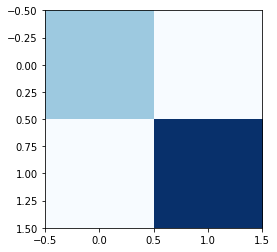

In [24]:
# Matrice di confusione
print("Matrice di confusione:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues); plt.show()

# Demo

In [64]:
face_detector = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
cap = cv.VideoCapture(0) #webcam

while(True):
    ret, img = cap.read()
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(img_gray)

    for (x,y,w,h) in faces:
        if w > 130: 
            cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) #draw rectangle to main image

            detected_face = img[int(y):int(y+h), int(x):int(x+w)] #crop detected face
            detected_face = cv.resize(detected_face, (224, 224)) #resize to 224x224

            captured_features = vgg_face_descriptor_features(detected_face).reshape(1,-1)
            dist, ind = tree.query(captured_features, k=1)
            y_pred = [y_train[int(i)] for i in ind][0]

            color=(0,255,0)
            
            if (dist <= 90):
                cv.putText(img, y_pred, (int(x+w+15), int(y-12)), cv.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                #connect face and text
            
                cv.line(img,(int((x+x+w)/2),y+15),(x+w,y-20),color,1)
                cv.line(img,(x+w,y-20),(x+w+10,y-20),color,1)

            else if (dist > 90): #if found image is too different
                cv.putText(img, 'unknown', (int(x+w+15), int(y-12)), cv.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    cv.imshow('img',img)

    if cv.waitKey(1) & 0xFF == ord('q'): #press q to quit
        break

#kill open cv things
cap.release()
cv.destroyAllWindows()

Questo modello funziona bene nella misura in cui deve distinguere tra le persone presenti, nel momento in cui si utilizzano le probabilita' predette per distinguere immagini di altri, la sua accuratezza non e' altrettanto precisa. 

# SVM

In [166]:
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf_svm = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced', probability=True), param_grid, cv=5) #radial basis

In [156]:
t0 = time()
#Train the model using the training sets
clf_svm.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf_svm.best_estimator_)

done in 15.504s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


c:\users\silvia.bordogna\appdata\local\continuum\anaconda2\envs\dsim\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [157]:
joblib.dump(clf_svm, 'face_svm.sav')

['face_svm.sav']

In [160]:
clf_svm = None
clf_svm = joblib.load('face_svm.sav') 

Test

In [161]:
#Predict the response for test dataset
y_pred = clf_svm.predict(X_test)

In [162]:
np.round(clf_svm.predict_proba(X_test),2)

array([[0.01, 0.99],
       [1.  , 0.  ],
       [0.01, 0.99],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.01, 0.99],
       [0.01, 0.99],
       [0.02, 0.98],
       [1.  , 0.  ],
       [0.01, 0.99],
       [0.01, 0.99],
       [0.01, 0.99],
       [0.01, 0.99],
       [0.13, 0.87],
       [1.  , 0.  ],
       [0.53, 0.47],
       [0.99, 0.01],
       [0.01, 0.99],
       [0.99, 0.01],
       [0.09, 0.91],
       [0.  , 1.  ],
       [0.03, 0.97]])

In [163]:
print("Report di classificazione:")
print(classification_report(y_test, y_pred))

Report di classificazione:
              precision    recall  f1-score   support

     giacomo       1.00      1.00      1.00         6
      silvia       1.00      1.00      1.00        16

   micro avg       1.00      1.00      1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22



# Demo SVM

In [145]:
face_detector = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
cap = cv.VideoCapture(0) #webcam

while(True):
    ret, img = cap.read()
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(img_gray)

    for (x,y,w,h) in faces:
        if w > 130: 
            cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) #draw rectangle to main image

            detected_face = img[int(y):int(y+h), int(x):int(x+w)] #crop detected face
            detected_face = cv.resize(detected_face, (224, 224)) #resize to 224x224

            captured_features = vgg_face_descriptor_features(detected_face).reshape(1,-1)
            pred_prob = clf_svm.predict_proba(captured_features)
            pred_label = clf_svm.predict(captured_features)[0]

            color=(0,255,0)
            
            if (np.max(pred_prob) >= 0.9):
                cv.putText(img, pred_label, (int(x+w+15), int(y-12)), cv.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                #connect face and text
            
                cv.line(img,(int((x+x+w)/2),y+15),(x+w,y-20),color,1)
                cv.line(img,(x+w,y-20),(x+w+10,y-20),color,1)

            if (np.max(pred_prob)<0.9): #if found image is too different
                cv.putText(img, 'unknown', (int(x+w+15), int(y-12)), cv.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    cv.imshow('img',img)

    if cv.waitKey(1) & 0xFF == ord('q'): #press q to quit
        break

#kill open cv things
cap.release()
cv.destroyAllWindows()

# Vector Similarity

Un approccio alternativo calcolando misure di similarita' dirrettamente sulle feature neurali.

In [105]:
def findCosineSimilarity(source_representation, test_representation):
    a = np.matmul(np.transpose(source_representation), test_representation)
    b = np.sum(np.multiply(source_representation, source_representation))
    c = np.sum(np.multiply(test_representation, test_representation))
    return 1 - (a / (np.sqrt(b) * np.sqrt(c)))
 
def findEuclideanDistance(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [132]:
cap = cv.VideoCapture(0) #webcam

while(True):
    ret, img = cap.read()
    
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(img_gray)

    for (x,y,w,h) in faces:
        if w > 130: 
            cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) #draw rectangle to main image

            detected_face = img[int(y):int(y+h), int(x):int(x+w)] #crop detected face
            detected_face = cv.resize(detected_face, (224, 224)) #resize to 224x224

            captured_representation = vgg_face_descriptor_features(detected_face)

            found = 0
            for n, i in enumerate(X_train):
                image_name = y_train[n]
                representation = i

                similarity = findCosineSimilarity(representation, captured_representation)
                if(similarity < 0.30):
                    cv.putText(img, image_name, (int(x+w+15), int(y-12)), cv.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                    
                    found = 1
                    break

            #connect face and text
            color=(0,255,0)
            cv.line(img,(int((x+x+w)/2),y+15),(x+w,y-20),color,1)
            cv.line(img,(x+w,y-20),(x+w+10,y-20),color,1)

            if(found == 0): #if found image is not in employee database
                cv.putText(img, 'unknown', (int(x+w+15), int(y-12)), cv.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    cv.imshow('img',img)

    if cv.waitKey(1) & 0xFF == ord('q'): #press q to quit
        break

#kill open cv things
cap.release()
cv.destroyAllWindows()